In [2]:
import pandas as pd
from ast import literal_eval

import geopandas

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from cartopy import crs as ccrs
import cartopy


tech_goodOrder = [
    "CCS",
    "BECCS",
    "DAC(CS)",
    "CCUS",
    "Soil Carbon Sequestration",
    "AR",
    "restoration of landscapes/peats",
    "Agroforestry",
    "Forest Management",
    "Biochar",
    "Enhanced Weathering (land based)",
    "Ocean alkalinity enhancement",
    "Blue Carbon",
    "Algae farming",
    "Ocean fertilization & Artificial upwelling",
    "General Literature on CDR/NET",   
]

exclude_technologies = ["CCS", "CCUS", "Algae farming","Other technologies",]

tech_goodOrder = [t for t in tech_goodOrder if t not in exclude_technologies]

col_ccs = [
'#e6550d',
'#fdae6b'
] # '#fc8d59','#d7301f']# oranges
col_ccs.reverse() 
col_biochar =  ['#f768a1'] # violet
col_landbased = ['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c'] # greens
col_landbased.reverse() 
col_ew_landbased =  ['#c994c7'] # bright violet
col_ocean = ['#f1eef6','#bdc9e1','#74a9cf'] #,'#0570b0'] # blues
col_gen_other = ['#636363', '#bdbdbd'] # greys

color_tech = (
             col_ccs + 
             col_landbased +  
             col_biochar + 
             col_ew_landbased + 
             col_ocean +
             col_gen_other
)

tc = {}
for i, tech in enumerate(tech_goodOrder):
    tc[tech]=color_tech[i]


### Load Data

In [3]:
df_ex = pd.read_csv("data/allIds__allTech_in_pub_from_run_2023-06-18.csv")
locs = pd.read_csv("data/2023-06-18_locations_firstAuthor.csv") 
locs.loc[locs.country_author=="Russian Federation","country_author"] = "Russia"
locs.loc[locs.country_author=="United States","country_author"] = "United States of America"
locs.loc[locs.country_author=="Chili","country_author"] = "Chile"

df_ex = df_ex.merge(locs[["id","country_author","continent_author"]], how="left", on="id")
df = df_ex.groupby(["id","country_author","continent_author","first_pred_tech"], as_index=False).agg({'all_pred_tech':lambda x:list(x)})

all_info = pd.read_csv("/home/sarah/projects/nets/data/wos_scopus_all.csv")
df = df.merge(all_info[["id", "year"]], on="id", how="left")

In [4]:
print(locs.shape)
print(locs.dropna(subset=["country_author"]).shape)

(21300, 4)
(21300, 4)


### Map

In [5]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
w = world[["name","iso_a3"]].rename(columns={"name": "country_author", "iso_a3":"ISO3"})

centroids = pd.read_csv("data/countries_centroids.csv").rename(columns={"ISO":"ISO2"})

iso = pd.read_csv("data/iso_codes.csv")
iso["Alpha-2 code"] = iso["Alpha-2 code"].apply(lambda x: x.replace('"','').replace(' ',''))
iso["Alpha-3 code"] = iso["Alpha-3 code"].apply(lambda x: x.replace('"','').replace(' ',''))
iso.rename(columns={"Alpha-2 code":'ISO2',
                    "Alpha-3 code":'ISO3'}, inplace=True)

w = w.merge(iso[['ISO2', 'ISO3']], on="ISO3", how="left")
w = w.merge(centroids[['longitude', 'latitude', 'ISO2']], on='ISO2', how="left")

w = w.drop_duplicates(subset=["country_author"])
w.loc[w["country_author"]=="Côte d'Ivoire","country_author"] = "Cote d'Ivoire"
w.loc[w["country_author"]=="Trinidad and Tobago","country_author"] = "Trinidad & Tobago"
w.loc[w["country_author"]=="Czechia","country_author"] = "Czech Republic"
w.loc[w["country_author"]=='Dem. Rep. Congo',"country_author"] = "Congo Democratic Republic"
w.loc[w["country_author"]=='Brunei',"country_author"] = "Brunei Darussalam"
w.loc[w["country_author"]=='Congo',"country_author"] = "Congo Brazzaville"
w.loc[w["country_author"]=='Dominican Rep.',"country_author"] = "Dominican Republic"


In [3]:
w

,country_author,ISO3,ISO2,longitude,latitude
0,Fiji,FJI,FJ,177.981446,-17.822471
1,Tanzania,TZA,TZ,34.818322,-6.355794
2,W. Sahara,ESH,EH,NaN,NaN
3,Canada,CAN,CA,-98.416805,57.550480
4,United States of America,USA,US,-96.331617,38.820809
...,...,...,...,...,...
185,Serbia,SRB,RS,20.856774,44.026799
186,Montenegro,MNE,ME,19.295051,42.736948
187,Kosovo,-99,NaN,18.164513,-21.908582
188,Trinidad & Tobago,TTO,TT,-61.372366,10.415516


In [6]:
counts_con = pd.DataFrame(df.country_author.value_counts()).reset_index()
counts_con.rename(columns={"country_author":"counts","index":"country_author",}, inplace=True)
print(sum(counts_con["counts"]))
counts_con = counts_con.merge(w, on="country_author", how="left")
print(sum(counts_con["counts"]))
counts_con.drop_duplicates(inplace=True)
print(sum(counts_con["counts"]))

21298
21298
21298


In [7]:
counts_con = pd.DataFrame(df.country_author.value_counts()).reset_index()
counts_con.rename(columns={"country_author":"counts","index":"country_author",}, inplace=True)
counts_con = counts_con.merge(w, on="country_author", how="left")
counts_con.drop_duplicates(inplace=True)

counts_con.loc[counts_con.country_author == "Kosovo", "latitude"] = 42.2338796
counts_con.loc[counts_con.country_author == "Kosovo", "longitude"] = 20.25426036
counts_con.loc[counts_con.country_author == "France", "latitude"] = 46.978407
counts_con.loc[counts_con.country_author == "France", "longitude"] = 2.011695
counts_con.loc[counts_con.country_author == "Taiwan", "latitude"] = 23.6978
counts_con.loc[counts_con.country_author == "Taiwan", "longitude"] = 120.9605
counts_con.loc[counts_con.country_author == "Singapore", "latitude"] = 1.287953
counts_con.loc[counts_con.country_author == "Singapore", "longitude"] = 103.851784
counts_con.loc[counts_con.country_author == "Mauritius", "latitude"] = -20.20665
counts_con.loc[counts_con.country_author == "Mauritius", "longitude"] = 57.6755
counts_con.loc[counts_con.country_author == "Namibia", "latitude"] = -22.967062
counts_con.loc[counts_con.country_author == "Namibia", "longitude"] = 18.4929993
counts_con.loc[counts_con.country_author == "Seychelles", "latitude"] = -22.967062
counts_con.loc[counts_con.country_author == "Seychelles", "longitude"] = 18.4929993
counts_con.loc[counts_con.country_author == "Bahrain", "latitude"] = 25.9434256
counts_con.loc[counts_con.country_author == "Bahrain", "longitude"] = 50.6014985
counts_con.loc[counts_con.country_author == "Norway", "latitude"] = 64.5783089 
counts_con.loc[counts_con.country_author == "Norway", "longitude"] = 17.888237

#bad_spain_record = counts_con.loc[(counts_con.country_author == "Spain")& (counts_con.latitude<40)].index
#counts_con.drop(index=bad_spain_record, inplace=True)

#counts_con = counts_con.loc[~pd.isna(counts_con.longitude)]
print(sum(counts_con["counts"]))

21298


In [8]:
counts_con.to_excel("data/countries_author_affil.xlsx")

In [8]:
counts_con["rel"] = counts_con["counts"]/sum(counts_con["counts"])
counts_con.sort_values("counts",ascending=False)

,country_author,counts,ISO3,ISO2,longitude,latitude,rel
0,China,6452,CHN,CN,104.691139,38.073255,0.302939
1,United States of America,2667,USA,US,-96.331617,38.820809,0.125223
2,United Kingdom,953,GBR,GB,-2.852944,53.978447,0.044746
3,Australia,927,AUS,AU,134.022772,-25.697338,0.043525
4,India,803,IND,IN,81.173004,23.586301,0.037703
...,...,...,...,...,...,...,...
118,Jamaica,1,JAM,JM,-77.303589,18.122079,0.000047
116,Seychelles,1,NaN,NaN,18.492999,-22.967062,0.000047
115,Albania,1,ALB,AL,20.061083,41.141659,0.000047
114,Kuwait,1,KWT,KW,47.563111,29.281361,0.000047


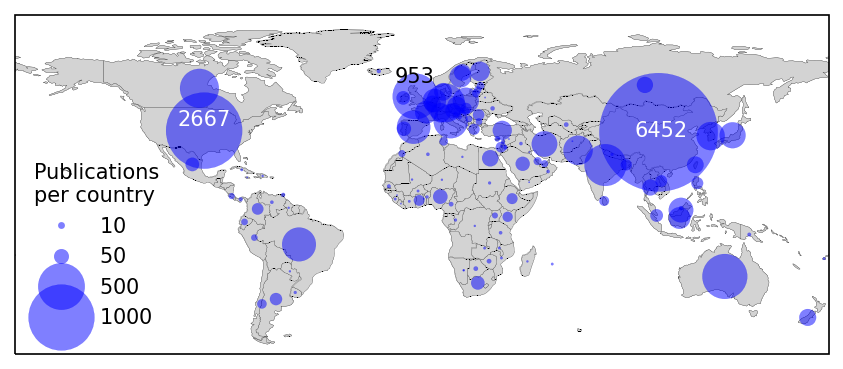

In [9]:
fig, ax = plt.subplots(dpi=150, figsize=(7,16))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_aspect(aspect=1.)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())

ax.coastlines(lw=0.1)

usa_count = counts_con.loc[counts_con.country_author=="United States of America", "counts"].values[0]
uk_count = counts_con.loc[counts_con.country_author=="United Kingdom", "counts"].values[0]
china_count = counts_con.loc[counts_con.country_author=="China", "counts"].values[0]
   
for i, row in world.iterrows():
        ax.add_geometries(
        [row['geometry']],facecolor = 'lightgrey', 
        crs=ccrs.PlateCarree(),lw=0.1, edgecolor= "black"
    )
sc = ax.scatter(counts_con.longitude, counts_con.latitude, s=0.5*counts_con.counts, zorder=10,color="blue", alpha=0.5,lw=0.1)
ax.text(-108, 41, usa_count, c="white", zorder=15)
ax.text(94, 36, china_count, c="white", zorder=15)
ax.text(-12, 60, uk_count, c="black", zorder=15)

plt.legend(*sc.legend_elements("sizes", num=[10,50,500,1000], c='blue'), 
           fontsize=10, loc="center left", bbox_to_anchor=(0, 0.32), frameon=False, 
           title='Publications\nper country')




### Bars

In [10]:
cont_groups = df.groupby(["continent_author"], as_index=False).size()
cont_groups_normalize = df_ex.groupby(["continent_author"], as_index=False).size()
cont_tech_groups = df_ex.groupby(["continent_author", "all_pred_tech"], as_index=False).size()
cont_tech_groups = cont_tech_groups.loc[cont_tech_groups.all_pred_tech.isin(tech_goodOrder)]

In [11]:
sum(cont_groups["size"])

21298

In [12]:
cont_groups["rel"] = cont_groups["size"]/sum(cont_groups["size"])
cont_groups

,continent_author,size,rel
0,Africa,608,0.028547
1,Asia,10178,0.477885
2,Europe,5224,0.245281
3,North America,3479,0.163349
4,Oceania,1066,0.050052
5,South America,743,0.034886


In [13]:
for con in cont_groups.continent_author.tolist():
    for tech_i in tech_goodOrder:
        if cont_tech_groups.loc[(cont_tech_groups.continent_author==con)&(cont_tech_groups.all_pred_tech==tech_i)].shape[0]==0:
            one_row = {'continent_author': con, 'all_pred_tech': tech_i, 'size': 0}
            cont_tech_groups = cont_tech_groups.append(one_row, ignore_index = True)
            
cont_tech_groups = pd.merge(cont_tech_groups, cont_groups_normalize.rename(columns={"size":"cont_size"}), on="continent_author", how="left")
cont_tech_groups["rel_num_studies"] = cont_tech_groups["size"]/cont_tech_groups["cont_size"]
cont_tech_groups = cont_tech_groups.sort_values(["continent_author", "all_pred_tech"])

/tmp/ipykernel_2815509/872672895.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cont_tech_groups = cont_tech_groups.append(one_row, ignore_index = True)
/tmp/ipykernel_2815509/872672895.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cont_tech_groups = cont_tech_groups.append(one_row, ignore_index = True)


In [14]:
cont_tech_groups.to_excel("data/pubs_per_tech_cont_author_affil.xlsx")
cont_groups.to_excel("data/pubs_per_continent_author_affil.xlsx")

/tmp/ipykernel_2815509/442145725.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['','','','','',])


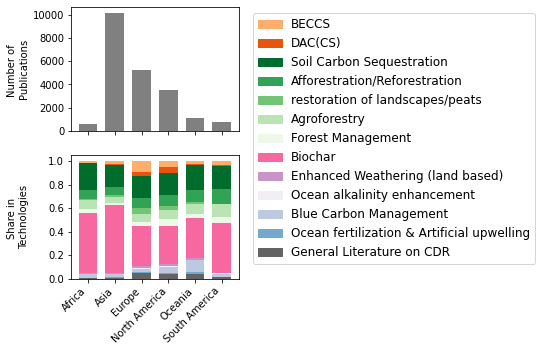

In [15]:
#mpl.rcParams.update({'font.size': 15,
#                     'svg.fonttype':'path',
#                     'font.family':'sans-serif',
#                     'font.sans-serif':'DejaVu Sans'
#                    })
fig = plt.figure(figsize=(3, 5))
gs = fig.add_gridspec(2,1)

techs = cont_tech_groups.all_pred_tech.unique()
conts = cont_tech_groups.continent_author.unique()

### ABSOLUTE NUMBER OF STUDIES
ax2 = plt.subplot(gs[0,0])

width=0.7
ticklabelsize=11
ax2.bar(conts, cont_groups["size"], width, color="grey")
ax2.set_ylabel('Number of \nPublications')
#ax2.set_yticklabels([0,2000,4000,6000])#,fontsize=ticklabelsize)
ax2.set_xticklabels(['','','','','',])


### SHARE IN TECHNOLGOY
ax3 = plt.subplot(gs[1,0])

tech_plot_rev = list(reversed(tech_goodOrder))
prev_values = np.zeros(len(cont_tech_groups.loc[cont_tech_groups.all_pred_tech=="BECCS", "rel_num_studies"]))
for tech_i in tech_plot_rev:
    ax3.bar(conts, cont_tech_groups.loc[cont_tech_groups.all_pred_tech==tech_i, "rel_num_studies"], width, bottom=prev_values,
            label=tech_i,
            color=tc[tech_i])
    prev_values += np.array(cont_tech_groups.loc[cont_tech_groups.all_pred_tech==tech_i, "rel_num_studies"])
ax3.set_ylabel('Share in \nTechnologies')
#ax3.set_xticklabels(fontsize=ticklabelsize)
plt.xticks(rotation=45, ha='right')


# legend
legend_labels = []
for tech_i in tech_goodOrder:
    if tech_i=="AR":
        lab="Afforestration/Reforestration"
    elif tech_i=="Blue Carbon":
        lab="Blue Carbon Management"
    elif tech_i=="General Literature on CDR/NET":
        lab="General Literature on CDR"
    elif "Enhanced " in tech:
        lab="Enhanced Wheathering"
    elif "(C" in tech:
        lab="DACCS"
    else:
        lab=tech_i
    legend_labels.append(mpatches.Patch(color=tc[tech_i], label=lab))

ax3.legend(handles=legend_labels, bbox_to_anchor=(1.05, 2.2), fontsize=12)



fig.align_ylabels([ax2,ax3])
fig.savefig("figures/SIfig_countries_bars.png", bbox_inches="tight", facecolor='white', edgecolor='none')

### Over- & Under-represented - Countries

In [16]:
# countries with most studies
num_countries = 5
# number of over- and underrepresented technologies
num_values = 3
countries = df.country_author.value_counts().index.tolist()[:num_countries]

#### Three ways to calculate data. 

In [17]:
# compare data for countries of special interest against all countries

all_countries_techs = (df_ex.groupby("all_pred_tech").size()/len(df_ex)).reset_index()
all_countries_techs = all_countries_techs.rename(columns={0:"rel_tech_all_countries"})

df_ex_con = df_ex.loc[df_ex.country_author.isin(countries)]
df_ex_con_norm = df_ex_con.groupby("country_author", as_index=False).size().rename(columns={"size":"paper_per_country"})
countries_tech = df_ex_con.groupby(["country_author","all_pred_tech"], as_index=False).size()
countries_tech = countries_tech.merge(df_ex_con_norm, on="country_author", how="left")
countries_tech["rel_tech_one_country"] = countries_tech["size"]/countries_tech["paper_per_country"] 

countries_tech = countries_tech.merge(all_countries_techs[["all_pred_tech", "rel_tech_all_countries"]], on="all_pred_tech", how="left")
countries_tech["div_from_all_countries"] = countries_tech["rel_tech_one_country"] - countries_tech["rel_tech_all_countries"]


values_plot = []
for c in countries:
    part = countries_tech.loc[countries_tech.country_author==c].copy()
    values_plot.append(part.sort_values("div_from_all_countries", ascending=False)[:3] )
    values_plot.append(part.sort_values("div_from_all_countries")[:3].sort_values("div_from_all_countries", ascending=False) )
    
    
values_plot = pd.concat(values_plot)

In [18]:
# compare data for countries of special interest against all other countries, i.e. each country is compared to all other countries
values_plot = []
for c in countries:
    all_other_countries_techs = df_ex.loc[df_ex.country_author!=c]
    all_other_countries_techs = (all_other_countries_techs.groupby("all_pred_tech").size()/len(all_other_countries_techs)).reset_index()
    all_other_countries_techs = all_other_countries_techs.rename(columns={0:"rel_tech_all_countries"})

    df_ex_con = df_ex.loc[df_ex.country_author==c].copy()
    df_ex_con_norm = df_ex_con.groupby("country_author", as_index=False).size().rename(columns={"size":"paper_per_country"})
    countries_tech = df_ex_con.groupby(["country_author","all_pred_tech"], as_index=False).size()
    countries_tech = countries_tech.merge(df_ex_con_norm, on="country_author", how="left")
    countries_tech["rel_tech_one_country"] = countries_tech["size"]/countries_tech["paper_per_country"] 

    countries_tech = countries_tech.merge(all_other_countries_techs[["all_pred_tech", "rel_tech_all_countries"]], on="all_pred_tech", how="left")
    countries_tech["div_from_all_countries"] = countries_tech["rel_tech_one_country"] - countries_tech["rel_tech_all_countries"]
    
    values_plot.append(countries_tech.sort_values("div_from_all_countries", ascending=False)[:3] )
    values_plot.append(countries_tech.sort_values("div_from_all_countries")[:3].sort_values("div_from_all_countries", ascending=False) )
    
    
values_plot = pd.concat(values_plot)
values_plot.to_excel("over_under_representation_author_afill.xlsx")

In [19]:
# compare data for countries of special interest against all other countries except China, 
# because it dominates the whole dataset with being 27% of the studies coming from China

values_plot = []
for c in countries:
    all_other_countries_techs = df_ex.loc[(df_ex.country_author!=c) & (df_ex.country_author!="China")]
    all_other_countries_techs = (all_other_countries_techs.groupby("all_pred_tech").size()/len(all_other_countries_techs)).reset_index()
    all_other_countries_techs = all_other_countries_techs.rename(columns={0:"rel_tech_all_countries"})

    df_ex_con = df_ex.loc[df_ex.country_author==c].copy()
    df_ex_con_norm = df_ex_con.groupby("country_author", as_index=False).size().rename(columns={"size":"paper_per_country"})
    countries_tech = df_ex_con.groupby(["country_author","all_pred_tech"], as_index=False).size()
    countries_tech = countries_tech.merge(df_ex_con_norm, on="country_author", how="left")
    countries_tech["rel_tech_one_country"] = countries_tech["size"]/countries_tech["paper_per_country"] 

    countries_tech = countries_tech.merge(all_other_countries_techs[["all_pred_tech", "rel_tech_all_countries"]], on="all_pred_tech", how="left")
    countries_tech["div_from_all_countries"] = countries_tech["rel_tech_one_country"] - countries_tech["rel_tech_all_countries"]
    
    values_plot.append(countries_tech.sort_values("div_from_all_countries", ascending=False)[:3] )
    values_plot.append(countries_tech.sort_values("div_from_all_countries")[:3].sort_values("div_from_all_countries", ascending=False) )
    
    
values_plot = pd.concat(values_plot)
values_plot.to_excel("over_under_representation_author_afill_all_countries_except_china.xlsx")

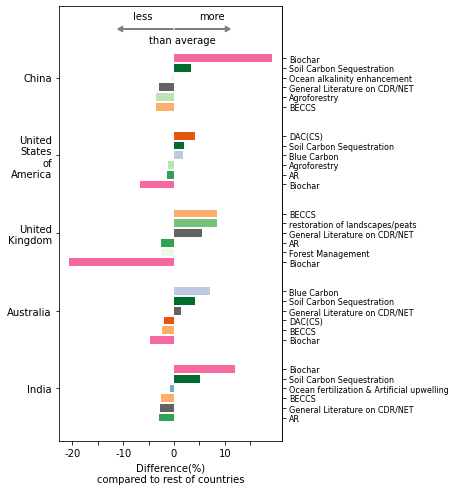

In [29]:
fig, ax = plt.subplots(figsize=(4,8))

ls_numbers = []
ls_techs = []
for idx, c in enumerate(countries):
    part = values_plot.loc[values_plot.country_author==c].copy()
    for i in range(6):
        start_val = 40-(idx*6+2*idx)
        ls_numbers.append(start_val-i)
        ls_techs.append(part["all_pred_tech"].tolist()[i])

for idx, c in enumerate(countries):
    part = values_plot.loc[values_plot.country_author==c].copy()
    for i in range(2*num_values):
        start_val = 40-(idx*6+2*idx)
        ax.barh([start_val-i], part["div_from_all_countries"].tolist()[i], align='center', color=tc[part["all_pred_tech"].tolist()[i]], zorder=10)
        
        
ax.set_yticks([38, 30, 22, 14, 6], [c.replace(' ','\n') for c in countries])
ax.set_xticks([-0.25,-0.20,-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['',-20,'',-10,'',0,'',10,''])
secay = ax.secondary_yaxis('right')
secay.set_yticks(ls_numbers,ls_techs, fontsize=8)
ax.set_xlabel("Difference(%)\ncompared to rest of countries")

ax.annotate("", xy=(0.5, 0.5), xytext=(0, 0),

            arrowprops=dict(arrowstyle="->"))

plt.arrow(0.001, 43, 0.1, 0, head_width=0.6, head_length=0.01,ec="grey",fc="grey")
plt.arrow(-0.001, 43, -0.1, 0, head_width=0.6, head_length=0.01,ec="grey",fc="grey")
ax.text(-0.08, 44, "less", c="black")
ax.text( 0.05, 44, "more", c="black")
ax.text(-0.05, 41.5, "than average", c="black")

fig.savefig('figures/firstAuthorAffil_countries_tech_moreLess.png', bbox_inches="tight", facecolor='white', edgecolor='none')


In [28]:
ls_techs

['Biochar',
 'Soil Carbon Sequestration',
 'Ocean alkalinity enhancement',
 'General Literature on CDR/NET',
 'Agroforestry',
 'DAC(CS)',
 'Soil Carbon Sequestration',
 'Blue Carbon',
 'Agroforestry',
 'AR',
 'BECCS',
 'restoration of landscapes/peats',
 'General Literature on CDR/NET',
 'AR',
 'Forest Management',
 'Blue Carbon',
 'Soil Carbon Sequestration',
 'General Literature on CDR/NET',
 'DAC(CS)',
 'BECCS',
 'Biochar',
 'Soil Carbon Sequestration',
 'Ocean fertilization & Artificial upwelling',
 'BECCS',
 'General Literature on CDR/NET',
 'Biochar',
 'Soil Carbon Sequestration',
 'Ocean alkalinity enhancement',
 'General Literature on CDR/NET',
 'Agroforestry',
 'DAC(CS)',
 'Soil Carbon Sequestration',
 'Blue Carbon',
 'Agroforestry',
 'AR',
 'BECCS',
 'restoration of landscapes/peats',
 'General Literature on CDR/NET',
 'AR',
 'Forest Management',
 'Blue Carbon',
 'Soil Carbon Sequestration',
 'General Literature on CDR/NET',
 'DAC(CS)',
 'BECCS',
 'Biochar',
 'Soil Carbon Seq

### Over- & Under-represented - World regions

In [ ]:
continents = df.continent_author.unique().tolist()
continents = sorted(continents)

In [ ]:
# compare data for countries of special interest against all countries

all_continents_techs = (df_ex.groupby("all_pred_tech").size()/len(df_ex)).reset_index()
all_continents_techs = all_continents_techs.rename(columns={0:"rel_tech_all_continents"})

df_ex_con_norm = df_ex.groupby("continent_author", as_index=False).size().rename(columns={"size":"paper_per_continent"})
continent_tech = df_ex.groupby(["continent_author","all_pred_tech"], as_index=False).size()
continent_tech = continent_tech.merge(df_ex_con_norm, on="continent_author", how="left")
continent_tech["rel_tech_one_continent"] = continent_tech["size"]/continent_tech["paper_per_continent"] 

continent_tech = continent_tech.merge(all_continents_techs[["all_pred_tech", "rel_tech_all_continents"]], on="all_pred_tech", how="left")
continent_tech["div_from_all_continents"] = continent_tech["rel_tech_one_continent"] - continent_tech["rel_tech_all_continents"]


values_plot = []
for c in continents:
    part = continent_tech.loc[continent_tech.continent_author==c].copy()
    values_plot.append(part.sort_values("div_from_all_continents", ascending=False)[:3] )
    values_plot.append(part.sort_values("div_from_all_continents")[:3].sort_values("div_from_all_continents", ascending=False) )
    
    
values_plot = pd.concat(values_plot)

Text(-0.05, 41.5, 'than average')

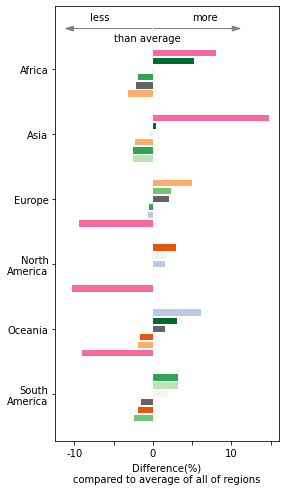

In [ ]:
fig, ax = plt.subplots(figsize=(4,8))

for idx, c in enumerate(continents):
    part = values_plot.loc[values_plot.continent_author==c].copy()
    for i in range(len(continents)):
        start_val = 40-(idx*6+2*idx)
        ax.barh([start_val-i], part["div_from_all_continents"].tolist()[i], align='center', color=tc[part["all_pred_tech"].tolist()[i]], zorder=10)
        
        
ax.set_yticks([38, 30, 22, 14, 6, -2], [c.replace(' ','\n') for c in continents])
ax.set_xticks([-0.25,-0.20,-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['',-20,'',-10,'',0,'',10,''])
ax.set_xlabel("Difference(%)\ncompared to average of all of regions")

ax.annotate("", xy=(0.5, 0.5), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->"))

plt.arrow(0.001, 43, 0.1, 0, head_width=0.6, head_length=0.01,ec="grey",fc="grey")
plt.arrow(-0.001, 43, -0.1, 0, head_width=0.6, head_length=0.01,ec="grey",fc="grey")
ax.text(-0.08, 44, "less", c="black")
ax.text( 0.05, 44, "more", c="black")
ax.text(-0.05, 41.5, "than average", c="black")

### All together

#### WITH WORLD REGIONS

/tmp/ipykernel_609949/2021365121.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0,1000,2000,3000])#,fontsize=ticklabelsize)
/tmp/ipykernel_609949/2021365121.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['','','','','',])


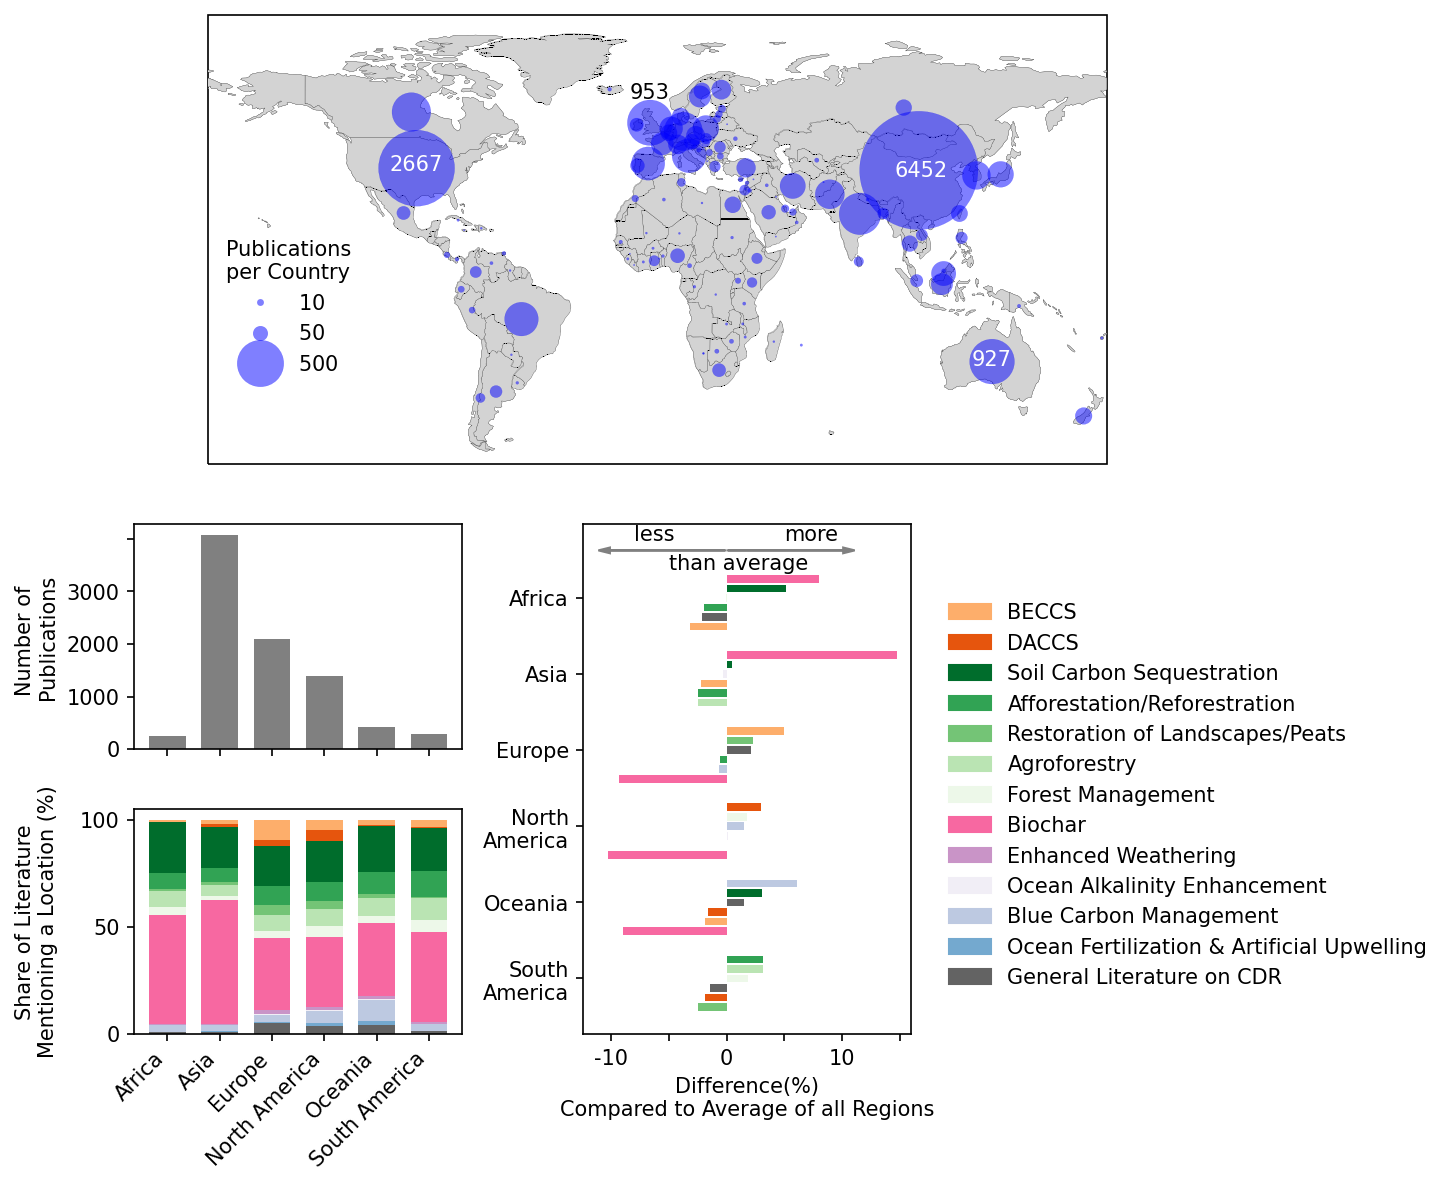

In [25]:
fig = plt.figure(figsize=(9, 9),dpi=150)
gs = fig.add_gridspec(3,5, width_ratios=[1,0.15,1,0.1,0.5], height_ratios=[2,1,1])


### MAP ###################################################
ax1 = fig.add_subplot(gs[0,0:],projection=ccrs.PlateCarree())

ax1.set_aspect(aspect=1.2)
ax1.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())

ax1.coastlines(lw=0.1)

usa_count = counts_con.loc[counts_con.country_author=="United States of America", "counts"].values[0]
uk_count = counts_con.loc[counts_con.country_author=="United Kingdom", "counts"].values[0]
china_count = counts_con.loc[counts_con.country_author=="China", "counts"].values[0]
australia_count = counts_con.loc[counts_con.country_author=="Australia", "counts"].values[0]
   
for i, row in world.iterrows():
        ax1.add_geometries(
        [row['geometry']],facecolor = 'lightgrey', 
         crs=ccrs.PlateCarree(),lw=0.1, edgecolor= "black", 
         zorder=10
    )
sc = ax1.scatter(counts_con.longitude, counts_con.latitude, s=0.5*counts_con.counts, zorder=10,color="blue", alpha=0.5,lw=0.1)


plt.legend(*sc.legend_elements("sizes", num=[10,50,500], c='blue'), 
           fontsize=10, loc="center left", bbox_to_anchor=(0, 0.35), frameon=False, 
           title='Publications\nper Country')

### ABSOLUTE NUMBER OF STUDIES ###############################
ax2 = fig.add_subplot(gs[1,0])

width=0.7
ticklabelsize=11
ax2.bar(conts, cont_groups["size"], width, color="grey")
ax2.set_ylabel('Number of \nPublications')
ax2.set_yticklabels([0,1000,2000,3000])#,fontsize=ticklabelsize)
ax2.set_xticklabels(['','','','','',])


### SHARE IN TECHNOLGOY ###############################
ax3 = fig.add_subplot(gs[2,0])

tech_plot_rev = list(reversed(tech_goodOrder))
prev_values = np.zeros(len(cont_tech_groups.loc[cont_tech_groups.all_pred_tech=="BECCS", "rel_num_studies"]))
for tech_i in tech_plot_rev:
    ax3.bar(conts, cont_tech_groups.loc[cont_tech_groups.all_pred_tech==tech_i, "rel_num_studies"], width, bottom=prev_values,
            label=tech_i,
            color=tc[tech_i])
    prev_values += np.array(cont_tech_groups.loc[cont_tech_groups.all_pred_tech==tech_i, "rel_num_studies"])
ax3.set_ylabel('Share of Literature\nMentioning a Location (%)')
ax3.set_yticks([0,0.5,1],[0,50,100])
plt.xticks(rotation=45, ha='right')


### legend
legend_labels = []
for tech in tech_goodOrder:
    if tech=="AR":
        lab="Afforestation/Reforestration"
    elif "restoration" in tech:
        lab="Restoration of Landscapes/Peats"
    elif tech=="Blue Carbon":
        lab="Blue Carbon Management"
    elif tech=="General Literature on CDR/NET":
        lab="General Literature on CDR"
    elif "Enhanced " in tech:
        lab="Enhanced Weathering"
    elif "welling" in tech:
        lab="Ocean Fertilization & Artificial Upwelling"
    elif 'alkalinity' in tech:
        lab="Ocean Alkalinity Enhancement"
    elif 'DAC(CS)' in tech:
        lab="DACCS"
    else:
        lab=tech
    legend_labels.append(mpatches.Patch(color=tc[tech], label=lab))

ax3.legend(handles=legend_labels, bbox_to_anchor=(4, 2), fontsize=10, ncol=1, frameon=False)

fig.align_ylabels([ax2,ax3])

### OVER/UNDERREPRESENTATION ###############################
ax4 = fig.add_subplot(gs[1:,2])
for idx, c in enumerate(continents):
    part = values_plot.loc[values_plot.continent_author==c].copy()
    for i in range(len(continents)):
        start_val = 40-(idx*6+2*idx)
        ax4.barh([start_val-i], part["div_from_all_continents"].tolist()[i], align='center', color=tc[part["all_pred_tech"].tolist()[i]], zorder=10)
        
        
ax4.set_yticks([38, 30, 22, 14, 6, -2], [c.replace(' ','\n') for c in continents])
ax4.set_xticks([-0.25,-0.20,-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['',-20,'',-10,'',0,'',10,''])
ax4.set_xlabel("Difference(%)\nCompared to Average of all Regions")

ax4.annotate("", xy=(0.5, 0.5), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->"))

plt.arrow(0.001, 43, 0.1, 0, head_width=0.6, head_length=0.01,ec="grey",fc="grey")
plt.arrow(-0.001, 43, -0.1, 0, head_width=0.6, head_length=0.01,ec="grey",fc="grey")
ax4.text(-0.08, 44, "less", c="black")
ax4.text( 0.05, 44, "more", c="black")
ax4.text(-0.05, 41, "than average", c="black")

ax1.text(-107, 38, usa_count, c="white", zorder=15)
ax1.text(95, 36, china_count, c="white", zorder=15)
ax1.text(126,-27, australia_count, c="white", zorder=15)
ax1.text(-11, 62, uk_count, c="black", zorder=15)

fig.savefig('figures/first_author_affil.png', bbox_inches="tight", facecolor='white', edgecolor='none')

IndexError: index 0 is out of bounds for axis 0 with size 0

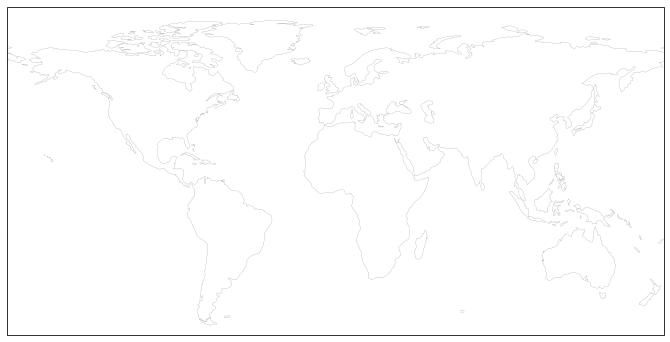

In [ ]:
fig = plt.figure(figsize=(20, 7))
gs = fig.add_gridspec(3,3, width_ratios=[4,1,1], height_ratios=[2,2,2])


### MAP ###################################################
ax1 = fig.add_subplot(gs[0:,0],projection=ccrs.PlateCarree())

ax1.set_aspect(aspect=1.2)
ax1.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())

ax1.coastlines(lw=0.1)

usa_count = counts_con.loc[counts_con.country_author=="United States", "counts"].values[0]
uk_count = counts_con.loc[counts_con.country_author=="United Kingdom", "counts"].values[0]
china_count = counts_con.loc[counts_con.country_author=="China", "counts"].values[0]
australia_count = counts_con.loc[counts_con.country_author=="Australia", "counts"].values[0]
   
for i, row in world.iterrows():
        ax1.add_geometries(
        [row['geometry']],facecolor = 'lightgrey', 
         crs=ccrs.PlateCarree(),lw=0.1, edgecolor= "black", 
         zorder=10
    )
sc = ax1.scatter(counts_con.longitude, counts_con.latitude, s=0.5*counts_con.counts, zorder=10,color="blue", alpha=0.5,lw=0.1)
ax1.text(-104, 43, usa_count, c="white", zorder=15)
ax1.text(97, 36, china_count, c="white", zorder=15)
ax1.text(129,-27, australia_count, c="white", zorder=15)
ax1.text(-8, 60, uk_count, c="black", zorder=15)

plt.legend(*sc.legend_elements("sizes", num=[10,50,500], c='blue'), 
           fontsize=10, loc="center left", bbox_to_anchor=(0, 0.35), frameon=False, 
           title='Publications\nper country')

### ABSOLUTE NUMBER OF STUDIES ###############################
ax2 = fig.add_subplot(gs[0,1])

width=0.7
ticklabelsize=11
ax2.bar(conts, cont_groups["size"], width, color="grey")
ax2.set_ylabel('Number of \npublications')
ax2.set_yticklabels([0,1000,2000,3000])#,fontsize=ticklabelsize)
ax2.set_xticklabels(['','','','','',])


### SHARE IN TECHNOLGOY ###############################
ax3 = fig.add_subplot(gs[1,1])

tech_plot_rev = list(reversed(tech_goodOrder))
prev_values = np.zeros(len(cont_tech_groups.loc[cont_tech_groups.all_pred_tech=="BECCS", "rel_num_studies"]))
for tech_i in tech_plot_rev:
    ax3.bar(conts, cont_tech_groups.loc[cont_tech_groups.all_pred_tech==tech_i, "rel_num_studies"], width, bottom=prev_values,
            label=tech_i,
            color=tc[tech_i])
    prev_values += np.array(cont_tech_groups.loc[cont_tech_groups.all_pred_tech==tech_i, "rel_num_studies"])
ax3.set_ylabel('Share of literature\nmentioning a location (%)')
ax3.set_yticks([0,0.5,1],[0,50,100])
plt.xticks(rotation=45, ha='right')


### legend
legend_labels = []
for tech_i in tech_goodOrder:
    if tech_i=="AR":
        lab="Afforestration/Reforestration"
    elif tech_i=="Blue Carbon":
        lab="Blue Carbon Management"
    elif tech_i=="General Literature on CDR/NET":
        lab="General Literature on CDR"
    elif "Enhanced " in tech:
        lab="Enhanced Wheathering"
    else:
        lab=tech_i
    legend_labels.append(mpatches.Patch(color=tc[tech_i], label=lab))

ax3.legend(handles=legend_labels, bbox_to_anchor=(2.5, -.5), fontsize=10, ncol=2, frameon=False)

fig.align_ylabels([ax2,ax3])

### OVER/UNDERREPRESENTATION ###############################
ax4 = fig.add_subplot(gs[:2,2])
for idx, c in enumerate(continents):
    part = values_plot.loc[values_plot.continent_author==c].copy()
    for i in range(len(continents)):
        start_val = 40-(idx*6+2*idx)
        ax4.barh([start_val-i], part["div_from_all_continents"].tolist()[i], align='center', color=tc[part["all_pred_tech"].tolist()[i]], zorder=10)
        
        
ax4.set_yticks([38, 30, 22, 14, 6, -2], [c.replace(' ','\n') for c in continents])
ax4.set_xticks([-0.25,-0.20,-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['',-20,'',-10,'',0,'',10,''])
ax4.set_xlabel("Difference(%)\ncompared to average of all of regions")

ax4.annotate("", xy=(0.5, 0.5), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->"))

plt.arrow(0.001, 43, 0.1, 0, head_width=0.6, head_length=0.01,ec="grey",fc="grey")
plt.arrow(-0.001, 43, -0.1, 0, head_width=0.6, head_length=0.01,ec="grey",fc="grey")
ax4.text(-0.08, 44, "less", c="black")
ax4.text( 0.05, 44, "more", c="black")
ax4.text(-0.05, 41.5, "than average", c="black")

fig.savefig('figures/first_author_affil.png', bbox_inches="tight", facecolor='white', edgecolor='none')

### Countries per year

In [15]:
number_countries_to_consider = 5
countries_list = df.country_author.value_counts().index[:number_countries_to_consider].tolist()

df["normalized_countries"] = df["country_author"]
df.loc[~df["normalized_countries"].isin(countries_list),"normalized_countries"] = "other country"

In [43]:
country_year = df.groupby(["year", "normalized_countries"],as_index=False).size()

for y in country_year.year.unique():
    for c in country_year.normalized_countries.unique():
        if country_year.loc[(country_year.normalized_countries==c)&(country_year.year==y)].shape[0]==0:
            one_row = {'year': y,'normalized_countries': c, 'size': 0}
            country_year = pd.concat([country_year, pd.DataFrame(one_row, index=[0])], ignore_index = True)
country_year = country_year.sort_values("year")

In [19]:
col = ['#bdbdbd'] + ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']  # colors + grey

other country
China
United States of America
United Kingdom
Australia
India


Text(0, 0.5, 'Share in \nTechnologies')

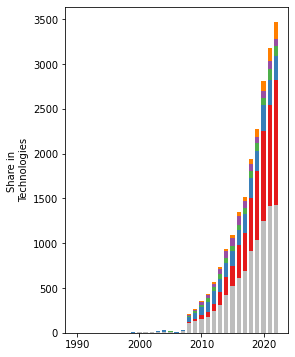

In [47]:
fig, ax = plt.subplots(figsize=(4,6))

width=0.7
ticklabelsize=11

prev_values = np.zeros(len(country_year.loc[country_year.normalized_countries=="other country", "size"]))
for i, country in enumerate(["other country"] + countries_list):
    print(country)
    ax.bar(country_year["year"].unique(), country_year.loc[country_year.normalized_countries==country, "size"], width, bottom=prev_values,
            label=country,
            color=col[i])
    prev_values += np.array(country_year.loc[country_year.normalized_countries==country, "size"])
ax.set_ylabel('Share in \nTechnologies')

### Save data in Excel-files

In [37]:
counts_con.to_excel('figures/fig_data/fig_firstAuthor__papers_per_country.xlsx', index=False)

In [42]:
sum(counts_con["counts"])

20625

In [38]:
cont_tech_groups.to_excel('figures/fig_data/fig_firstAuthor__papers_per_contient_tech.xlsx', index=False)

### Some analysis for paper

In [39]:
totNum = cont_tech_groups.groupby("continent_author").sum()["size"].sum()

In [40]:
cont_tech_groups.groupby("continent_author").sum()/totNum

,size,cont_size,rel_num_studies
continent_author,,,
Africa,0.028843,0.374959,0.000037
Asia,0.468313,6.088070,0.000037
Europe,0.249349,3.241532,0.000037
North America,0.164067,2.132876,0.000037
Oceania,0.051374,0.667865,0.000037
South America,0.038054,0.494697,0.000037


In [74]:
counts_con.counts/counts_con.counts.sum()

0      0.297314
1      0.135257
2      0.048457
3      0.048057
4      0.036743
         ...   
124    0.000057
126    0.000057
127    0.000057
128    0.000057
129    0.000057
Name: counts, Length: 109, dtype: float64

In [88]:
values_plot

,country_author,all_pred_tech,size,paper_per_country,rel_tech_one_country,rel_tech_all_countries,div_from_all_countries
3,China,Biochar,3865,6685,0.578160,0.399421,0.178739
11,China,Soil Carbon Sequestration,1455,6685,0.217651,0.189945,0.027706
9,China,Ocean alkalinity enhancement,4,6685,0.000598,0.004702,-0.004104
1,China,Agroforestry,317,6685,0.047420,0.070951,-0.023531
8,China,General Literature on CDR/NET,33,6685,0.004936,0.035023,-0.030087
2,China,BECCS,99,6685,0.014809,0.056061,-0.041252
5,United States,DAC(CS),168,3029,0.055464,0.015955,0.039509
4,United States,Blue Carbon,169,3029,0.055794,0.032205,0.023589
7,United States,Forest Management,154,3029,0.050842,0.027414,0.023428
12,United States,restoration of landscapes/peats,74,3029,0.024431,0.027562,-0.003132
